# Sistem Rekomendasi Film | Collaborative & Content-Based Filtering

## A. Business Understanding
Dalam menghadapi tantangan banyaknya pilihan film yang tersedia, sistem rekomendasi terus berkembang dengan mengadopsi berbagai pendekatan teknologi, seperti machine learning dan analisis data perilaku pengguna. Pendekatan ini memungkinkan sistem untuk mempelajari pola tontonan, memberi prediksi yang lebih akurat, dan menyesuaikan rekomendasi secara dinamis. Tidak hanya itu, sistem yang cerdas juga dapat mengenali perubahan preferensi pengguna seiring waktu, sehingga rekomendasi yang diberikan tetap relevan. Dengan demikian, sistem rekomendasi tidak hanya meningkatkan pengalaman pengguna, tetapi juga membantu platform streaming mempertahankan loyalitas pengguna dan meningkatkan keterlibatan mereka.

## B. Data Understanting

## 1. Import Library

In [ ]:
import ast
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

# Library Visualisasi dan analisis Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Library deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Library pemrosesan dan metrik
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 2. Data Loading

In [2]:
# Menyimpan data dalam variabel
movies = pd.read_csv("dataset/movies_metadata.csv")
credits = pd.read_csv("dataset/credits.csv")
keywords = pd.read_csv("dataset/keywords.csv")
ratings = pd.read_csv("dataset/ratings.csv")
ratings_small = pd.read_csv("dataset/ratings_small.csv")
links_small = pd.read_csv("dataset/links_small.csv")
links = pd.read_csv("dataset/links.csv")

In [3]:
# movies
print(f'Jumlah data movies adalah --> {movies["id"].nunique()}')

print('_'*75)

# credits
print(f'Jumlah data rating keseluruhan --> {len(ratings)}')
print(f'Jumlah pengguna yang memberikan rating ke film --> {ratings["userId"].nunique()}')
print(f'Jumlah film yang memiliki rating --> {ratings["movieId"].nunique()}')

print('_'*75)

# ratings_small
print(f'Jumlah data rating_small keseluruhan --> {len(ratings_small)}')
print(f'Jumlah pengguna yang memberikan rating ke film --> {ratings_small["userId"].nunique()}')
print(f'Jumlah film yang memiliki rating --> {ratings_small["movieId"].nunique()}')

print('_'*75)

# links
print(f'Jumlah data links dari imdb dan tmdb dari masing-masing movie   --> {len(links)}')
# links_small
print(f'Jumlah data links_small dari imdb dan tmdb dari masing-masing movie  --> {len(links_small)}')

print('_'*75)

# credits
print(f'Jumlah data pemain dan kru --> {len(credits)}')
print(f'Jumlah data keywords --> {len(keywords)}')

Jumlah data movies adalah --> 45436
___________________________________________________________________________
Jumlah data rating keseluruhan --> 26024289
Jumlah pengguna yang memberikan rating ke film --> 270896
Jumlah film yang memiliki rating --> 45115
___________________________________________________________________________
Jumlah data rating_small keseluruhan --> 100004
Jumlah pengguna yang memberikan rating ke film --> 671
Jumlah film yang memiliki rating --> 9066
___________________________________________________________________________
Jumlah data links dari imdb dan tmdb dari masing-masing movie   --> 45843
Jumlah data links_small dari imdb dan tmdb dari masing-masing movie  --> 9125
___________________________________________________________________________
Jumlah data pemain dan kru --> 45476
Jumlah data keywords --> 46419


Dalam penelitian ini, hanya akan menggunakan dua dataset, yaitu **movies_metadata.csv** dan **ratings_small.csv**, karena kedua dataset ini cukup untuk membangun sistem rekomendasi.

## 3. Exploratory Data Analysis (EDA)

Tujuan tahap Exploratory Data Analysis (EDA) untuk menganalisis distribusi film, rating, serta memahami hubungan antar fitur dalam dataset.

### 3.1. Deskripsi Variabel

#### 3.1.1. File Movies

In [4]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Berdasarkan output di atas, variabel `movies` terdiri dari **45.466 baris** dan **24 kolom**. Adapun deskripsi fitur-fiturnya dapat dilihat sebagai berikut:

| **Variabel**                | **Keterangan** | **Tipe Data** |
|----------------------------|----------------|---------------|
| `adult`                    | Menandakan apakah film mengandung konten dewasa. Biasanya bernilai `True` atau `False`. | object        |
| `belongs_to_collection`    | Menunjukkan apakah film termasuk dalam suatu seri atau koleksi tertentu, seperti franchise film. Biasanya berbentuk string atau format JSON. | object        |
| `budget`                   | Total anggaran produksi film, umumnya dalam satuan dolar AS (USD). | object        |
| `genres`                   | Daftar genre yang dimiliki film, misalnya Action, Drama, atau Comedy. Tersedia dalam bentuk list atau JSON. | object        |
| `homepage`                 | Tautan ke situs web resmi film. | object        |
| `id`                       | ID unik film di dalam sistem database (seperti TMDb). | object        |
| `imdb_id`                  | ID khusus film pada database IMDb. | object        |
| `original_language`        | Kode bahasa asli film, mengikuti format ISO 639-1 (contoh: `en` untuk Bahasa Inggris). | object        |
| `original_title`           | Judul asli film sesuai dengan versi bahasa produksinya. | object        |
| `overview`                 | Ringkasan atau sinopsis singkat mengenai cerita film. | object        |
| `popularity`               | Skor popularitas film yang dihitung berdasarkan sistem tertentu dari platform. | object        |
| `poster_path`              | Path atau lokasi file gambar poster film, biasanya digunakan bersama URL dasar untuk mengakses gambar. | object        |
| `production_companies`     | Informasi tentang studio atau perusahaan yang memproduksi film, biasanya berupa daftar dalam format JSON. | object        |
| `production_countries`     | Negara tempat film diproduksi, tersedia dalam format JSON yang berisi nama dan kode negara. | object        |
| `release_date`             | Tanggal film dirilis, dengan format `YYYY-MM-DD`. | object        |
| `revenue`                  | Pendapatan kotor yang dihasilkan film, biasanya dalam USD. | float64       |
| `runtime`                  | Durasi total film dalam satuan menit. | float64       |
| `spoken_languages`         | Bahasa yang digunakan dalam percakapan film, dicatat dalam format JSON. | object        |
| `status`                   | Status distribusi film, seperti `Released` atau `In Production`. | object        |
| `tagline`                  | Slogan atau kutipan promosi yang terkait dengan film. | object        |
| `title`                    | Judul utama film yang umum digunakan untuk distribusi atau promosi. | object        |
| `video`                    | Menunjukkan apakah film memiliki video tambahan terkait. Nilainya berupa `True` atau `False`. | object        |
| `vote_average`             | Rata-rata skor atau penilaian yang diberikan oleh pengguna (misalnya IMDb atau TMDb) terhadap film, biasanya dalam skala 1–10. | float64       |
| `vote_count`               | Jumlah total suara atau penilaian yang diterima oleh film. | float64       |


#### 3.1.2. File Ratings

In [6]:
ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
ratings_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Berdasarkan output di atas, variabel `ratings_small` terdiri dari subset rating lengkap yaitu **100.003 baris** dan **4 kolom**. Adapun deskripsi fitur-fiturnya dapat dilihat sebagai berikut:

| **Variabel**   | **Keterangan**                                                                                                                                      | **Tipe Data** |
|----------------|------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|
| `userId`       | Merupakan identitas unik yang diberikan kepada setiap pengguna yang memberikan rating. Digunakan untuk membedakan antar pengguna secara anonim.     | int64         |
| `movieId`      | Kode unik yang mewakili setiap film yang dinilai oleh pengguna. ID ini dapat digunakan untuk mengakses informasi lebih lengkap tentang film tersebut.| int64         |
| `rating`       | Skor atau nilai evaluasi yang diberikan pengguna terhadap sebuah film, biasanya dalam skala 1 sampai 5. Semakin tinggi nilainya, semakin positif penilaian pengguna. | float64       |
| `timestamp`    | Menunjukkan kapan rating diberikan.                                                                                                                 | int64         |

Terdapat tipe data pada fitur `id` di dataframe `movies` (object) dan fitur `movieId` di `ratings` (int64) tidak konsisten. Selanjutnya kan mengubah tipe datanya ke int64 agar seragam.

### 3.2. Hitung Total Data dari Dataset

In [8]:
print(f'Jumlah movies adalah --> {movies["id"].nunique()}')
print(f'Jumlah rating adalah --> {len(ratings_small)}')
print(f'Jumlah pengguna yang memberikan rating adalah --> {ratings_small["userId"].nunique()}')
print(f'Jumlah film yang memiliki rating adalah --> {ratings_small["movieId"].nunique()}')

Jumlah movies adalah --> 45436
Jumlah rating adalah --> 100004
Jumlah pengguna yang memberikan rating adalah --> 671
Jumlah film yang memiliki rating adalah --> 9066


Dari output diatas terdapat 45.436 film pada dataset movies, 9066 film yang memiliki rating dan 671 pengguna yang memberikan rating pada film.

### 3.3. Informasi Statistik Dataset 

In [9]:
movies.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


- Insight:

  - Vote Average menunjukkan rata-rata rating film, yang dimulai dari 0 dengan  berkisar antara 5 hingga 7, lalu nilai tertinggi 10.

  - Vote Count menunjukkan banyaknya ulasan yang diterima film. Banyak film yang memiliki jumlah rating rendah (bahkan ada film yang memiliki jumlah rating 0), namun ada beberapa film yang mendapatkan ribuan jumlah rating.

In [10]:
ratings_small.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


- Insight:

    - UserId menunjukkan pengguna yang memberikan rating.

    - MovieId menunjukkan film yang dinilai/memiliki rating.

    - Rating menunjukkan bahwa sebagian besar rating yang diberikan adalah 3 hingga 5, dengan rata-rata rating adalah 3.543608

    - Timestamp menunjukkan waktu ketika rating diberikan. Timestamp dicatat dalam bentuk waktu UNIX.

### 3.4. Distribusi Rating Film

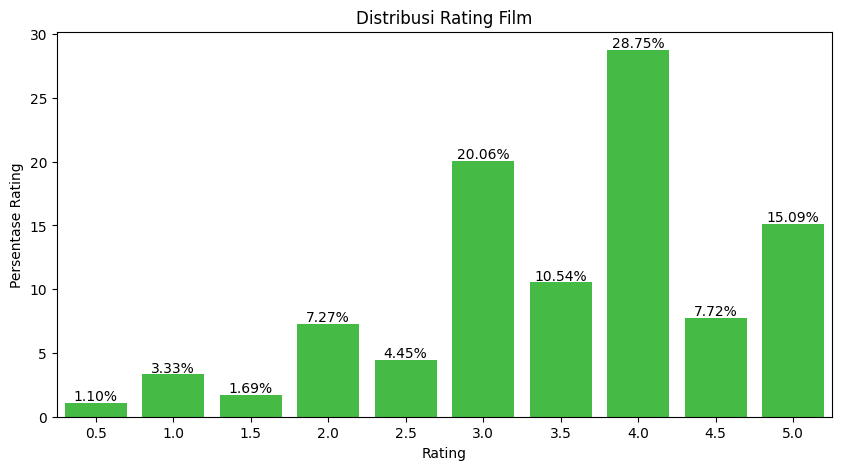

In [11]:
# Data rating dalam persen
count_rating = ratings_small.groupby('rating')['userId'].count()
count_rating_percentage = count_rating/len(ratings_small) * 100

# Barplot distribusi rating
plt.figure(figsize=(10,5))
ax = sns.barplot(x=count_rating.index, y=count_rating_percentage, color='limegreen')
for p in ax.patches:
  plt.text(p.get_x() + p.get_width()/2., p.get_height()+0.5, f'{p.get_height():.2f}%', ha='center', va='center')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Persentase Rating')
plt.show()

Insight:

**1. Rating 4.0 Mendominasi (28.75%)**

* Ini menunjukkan bahwa sebagian besar pengguna **cenderung memberi nilai tinggi tapi tidak maksimal**.
* Kemungkinan besar pengguna bersikap realistis, tidak langsung kasih 5 kecuali filmnya sangat berkesan.

**2. Rating 3.0 Juga Cukup Populer (20.06%)**

* Rating ini bisa dianggap sebagai **rating “netral” atau cukup”**.
* Ini menandakan banyak pengguna merasa film yang mereka tonton tidak terlalu bagus, tapi juga tidak jelek.

**3. Rating 5.0 Masih Tinggi (15.09%)**

* Cukup banyak pengguna yang memberi **rating sempurna**.
* Ini bisa digunakan sebagai sinyal bahwa film tersebut benar-benar disukai, meskipun tetap perlu diperiksa jumlah user-nya.

**4. Rating Rendah Jarang Diberikan**

* Rating 0.5, 1.0, dan 1.5 masing-masing **kurang dari 3.5%**.
* Ini mengindikasikan bahwa pengguna jarang memberi nilai sangat rendah.
* Bisa jadi karena:

  * Mereka jarang menonton film yang jelek.
  * Atau memang enggan memberi rating rendah (bias persepsi pengguna).

### 3.5. Melihat Distribusi Genre dalam Film

In [12]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Berdasarkan struktur kolom `genres`, datanya berupa **list of dictionaries**. Jadi, diperlukan ekstrak name dari setiap dict dalam list tersebut untuk tiap baris, lalu menghitung kemunculan masing-masing genre.

Top 10 Genre Film Terbanyak:
             Genre  Jumlah
0            Drama   20265
1           Comedy   13182
2         Thriller    7624
3          Romance    6735
4           Action    6596
5           Horror    4673
6            Crime    4307
7      Documentary    3932
8        Adventure    3496
9  Science Fiction    3049


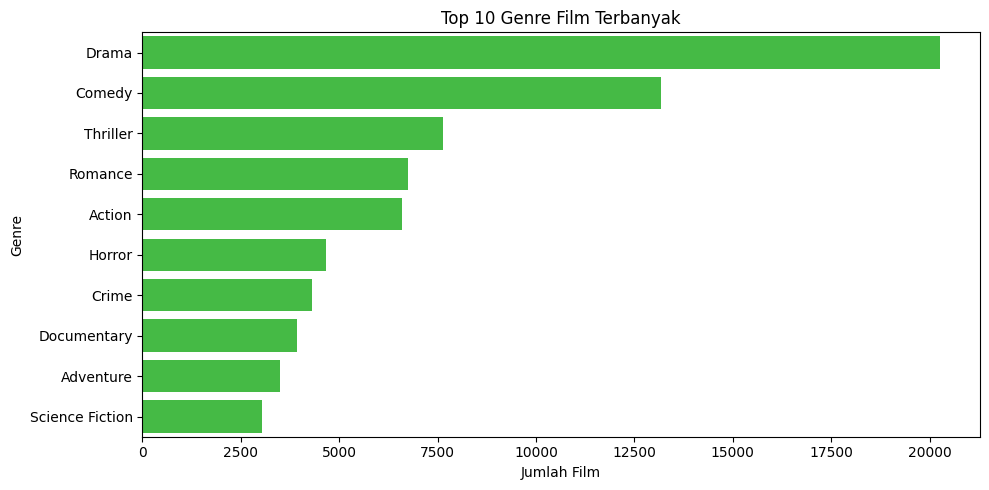

In [13]:
# Pastikan kolom 'genres' diparsing dengan benar
movies_genres = movies.copy()
movies_genres['genres'] = movies_genres['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# Ekstrak nama genre dan simpan dalam satu list panjang
all_genres = []
for genre_list in movies_genres['genres']:
    all_genres.extend([genre['name'] for genre in genre_list])

# Hitung frekuensi masing-masing genre
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Tampilkan sebagai tabel
genre_table = genre_counts.reset_index()
genre_table.columns = ['Genre', 'Jumlah']
print("Top 10 Genre Film Terbanyak:")
print("=======================================")
print(genre_table)

# Visualisasi
plt.figure(figsize=(10,5))
sns.barplot(x='Jumlah', y='Genre', data=genre_table, color='limegreen')
plt.title('Top 10 Genre Film Terbanyak')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Genre adalah fitur penting dalam content-based filtering. Adapun insight dari output di atas dapat dilihat sebagai berikut:

1. **Dominasi Genre Drama**

   * Dengan **20.265 film**, *Drama* menjadi genre paling umum dalam dataset.
   * Ini wajar karena drama adalah genre yang fleksibel dan sering digabungkan dengan genre lain seperti romance, crime, atau thriller.

2. **Popularitas Genre Komedi**

   * *Comedy* berada di posisi kedua dengan **13.182 film**.
   * Genre ini biasanya memiliki audience yang luas dan relatif mudah diproduksi dengan variasi yang banyak, baik standalone maupun campuran.

3. **Thriller, Romance, dan Action Juga Signifikan**

   * Ketiganya masing-masing berada di angka **7.624**, **6.735**, dan **6.596**.
   * *Thriller* dan *Action* sering diminati karena ketegangan dan visual yang menarik, sedangkan *Romance* banyak diminati karena keterkaitan emosional.

4. **Genre-Genre Khusus Mulai dari Posisi 6 ke Bawah**

   * *Horror*, *Crime*, dan *Documentary* berada di posisi menengah ke bawah tapi tetap cukup banyak.
   * *Science Fiction* meskipun termasuk genre populer secara global, dalam dataset ini hanya muncul **3.049 kali**, menunjukkan genre ini tidak sebanyak drama atau komedi secara keseluruhan.

### 3.6. Analisis Rating dengan Film

                                    user_rating_mean  tmdb_imdb_rating  \
title                                                                    
Terminator 3: Rise of the Machines          4.256173               5.9   
The Million Dollar Hotel                    4.487138               5.9   
Solaris                                     4.134426               7.7   
The 39 Steps                                4.221649               7.4   
Monsoon Wedding                             3.706204               6.8   
Once Were Warriors                          4.303279               7.6   
Three Colors: Red                           3.945175               7.8   
Men in Black II                             4.256696               6.1   
The Passion of Joan of Arc                  3.483945               8.2   
Silent Hill                                 3.674419               6.3   

                                    count_user_voted  
title                                                 
T

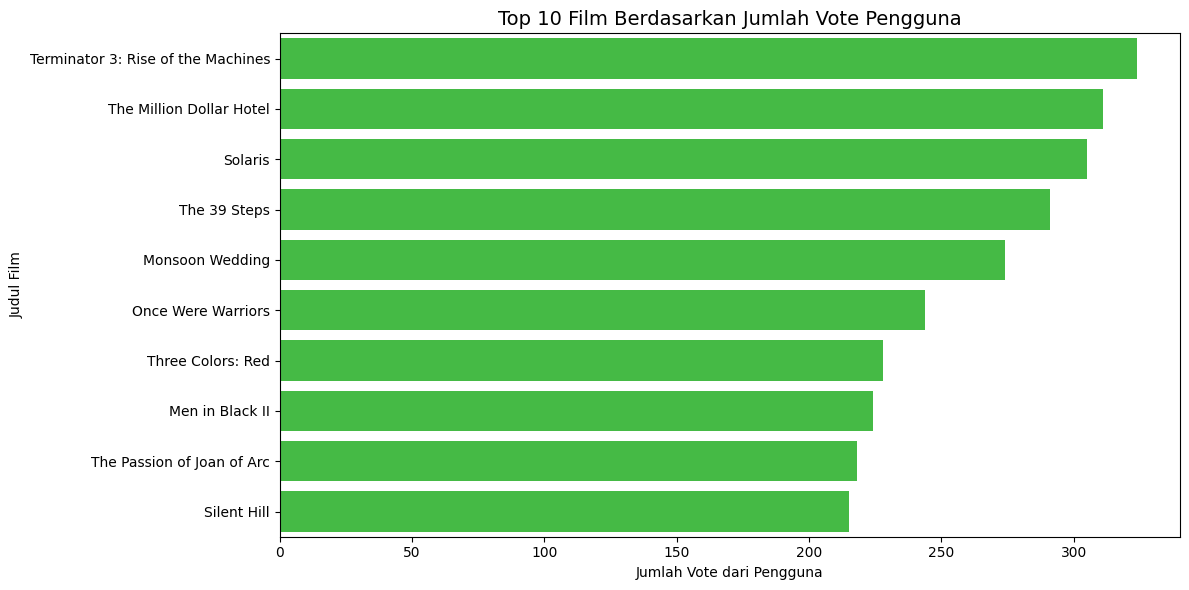

In [14]:
# Copy data movie untuk analisis
movies_copy = movies.copy()

# Drop baris yang id-nya kosong
movies_copy = movies_copy.dropna(subset=['id'])

# Saring id dari movie yang hanya berupa angka
movies_copy = movies_copy[movies_copy['id'].apply(lambda x: str(x).isnumeric())]

# Konversi id movie dari object ke int
movies_copy['id'] = movies_copy['id'].astype('int')

# Ubah nama kolom id ke movieId agar bisa melakukan join dengan dataframe rating
movies_copy = movies_copy.rename(columns={'id':'movieId'})

# Join ke dataframe untuk mencari movie yang telah diberikan rating
movie_ratings = pd.merge(left=movies_copy, right=ratings_small, on='movieId', how='inner')

# Kelompokkan berdasarkan judul movie
df_movie_rating = movie_ratings.groupby('title').agg(
    user_rating_mean=('rating', 'mean'),                # Rata-rata rating dari pengguna
    tmdb_imdb_rating=('vote_average', 'first'),         # Rating dari TMDB/IMDB (satu nilai unik per film)
    count_user_voted=('userId', 'count')                      # Jumlah rating yang masuk dari pengguna
)

# Urutkan berdasarkan jumlah vote terbanyak
df_movie_rating = df_movie_rating.sort_values(by='count_user_voted', ascending=False)

# Tampilkan Top 10 film berdasarkan jumlah vote
print(df_movie_rating.head(10))


# Reset index agar kolom title bisa digunakan dalam visualisasi
top10 = df_movie_rating.head(10).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(
    y='title',
    x='count_user_voted',
    data=top10,
    color='limegreen'
)

plt.title('Top 10 Film Berdasarkan Jumlah Vote Pengguna', fontsize=14)
plt.xlabel('Jumlah Vote dari Pengguna')
plt.ylabel('Judul Film')
plt.tight_layout()
plt.show()



Insight:

1. **Film dengan Popularitas Tertinggi (jumlah vote terbanyak)**

   * **Terminator 3: Rise of the Machines** menempati posisi teratas dengan **324 vote** dari pengguna.
   * Menariknya, meskipun film ini tidak mendapat rating tinggi dari TMDB (5.9), pengguna justru memberikan rating yang **relatif tinggi (4.26)**.

2. **Perbedaan Rating Pengguna vs TMDB**

   * Ada beberapa film dengan **gap signifikan** antara rating pengguna dan rating TMDB/IMDB:

     * **The Passion of Joan of Arc** → Rating pengguna: **3.48**, tapi rating TMDB: **8.2** → menandakan film ini lebih diapresiasi secara sinematik (kritikus), tapi kurang disukai oleh pengguna biasa.
     * **Three Colors: Red** juga mendapat rating tinggi di TMDB (**7.8**), tapi rating pengguna hanya **3.95**.

3. **Konsistensi Rating**

   * **Solaris** punya rating tinggi dari TMDB (**7.7**) dan pengguna juga cukup tinggi (**4.13**), menunjukkan konsistensi penerimaan positif dari dua sumber.


## 4. Data Preparation Umum

Di tahap sebelumnya dapat disimpulkan bahwa sistem rekomendasi Content-Based Filtering maupun Collaborative Filtering cocok diterapkan pada dataset ini. Pada tahapan Data Preparation, dilakukan proses pembersihan data, sehingga data bebas dari missing values dan data duplikat.

### 4.1. Pemilihan Fitur yang Relevan
Pada tahap ini, hanya beberapa fitur yang relevan atau perlu untuk membangun sistem rekomendasi yang akan diambil yaitu `id`, `genres`, dan `title` dari dataframe **movies**. Sedangkan pada dataframe **ratings**, akan dihapus kolom `timestamp`.

In [15]:
df_movies = movies[['id','genres', 'title']]
df_movies.head()

,id,genres,title
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II


In [16]:
df_ratings = ratings_small.drop(columns='timestamp')
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### 4.2. Penyesuaian Nama dan Tipe Data
- Dari tahap EDA diketahui bahwa perlu dilakukan penyesuaian tipe data pada kolom id di dataframe **movies** agar konsisten dengan tipe data int64 pada kolom `movieId` di dataframe **ratings**.
- Setelah itu, nama kolom `id` pada dataframe **movies** perlu diubah menjadi `movieId` agar dapat melakukan join antar dataframe.

In [17]:
# Pastikan id hanya berisi angka (numerik) dan filter nilai yang valid
df_movies = df_movies[df_movies['id'].apply(lambda x: x.isnumeric())]

# Ubah tipe data id menjadi int64
df_movies['id'] = df_movies['id'].astype('int64')

# Ganti nama kolom 'id' menjadi 'movieId'
df_movies = df_movies.rename(columns={'id': 'movieId'})

df_movies.head()

,movieId,genres,title
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II


In [18]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45463 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  45463 non-null  int64 
 1   genres   45463 non-null  object
 2   title    45460 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


### 4.3. Mengubah Format Fitur Genre
- Mengubah format kolom genres yang berisi data dalam bentuk list of dictionaries menjadi format list of genre names agar lebih mudah dalam analisis dan pemrosesan lebih lanjut.
- Llist kosong pada kolom genres diubah menjadi **NaN** agar baris-baris yang tidak memiliki genre dapat dengan mudah diidentifikasi dan dihapus saat diperlukan. Langkah ini membantu meminimalkan gangguan dari data yang tidak relevan dalam analisis.

In [19]:
# Mengubah string yang berbentuk list of dictionaries menjadi objek list menggunakan literal_eval
df_movies['genres'] = df_movies['genres'].apply(lambda x: literal_eval(x) if pd.notnull(x) else np.nan)

# Mengambil nama genre dari setiap dictionary di dalam list 'genres'.
# Jika list kosong, ubah menjadi NaN
df_movies['genres'] = df_movies['genres'].apply(lambda x: [i['name'] for i in x] if len(x) > 0 else np.nan)

df_movies.head()

,movieId,genres,title
0,862,"[Animation, Comedy, Family]",Toy Story
1,8844,"[Adventure, Fantasy, Family]",Jumanji
2,15602,"[Romance, Comedy]",Grumpier Old Men
3,31357,"[Comedy, Drama, Romance]",Waiting to Exhale
4,11862,[Comedy],Father of the Bride Part II


### 4.4. Menggabungkan dataframe *movies* dan *ratings*
Pada tahap ini dilakukan penggabungan antara DataFrame movies dan ratings. Ini bertujuan supaya dapat menganalisa setiap film dengan rating yang diberikan oleh pengguna, sehingga informasi mengenai rating film dapat disertakan.

In [20]:
# Menggabungkan dataframe
df_movies_ratings = pd.merge(left=df_movies, right=df_ratings, on='movieId', how='inner')
df_movies_ratings.head()

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
1,949,"[Action, Crime, Drama, Thriller]",Heat,102,4.0
2,949,"[Action, Crime, Drama, Thriller]",Heat,232,2.0
3,949,"[Action, Crime, Drama, Thriller]",Heat,242,5.0
4,949,"[Action, Crime, Drama, Thriller]",Heat,263,3.0


### 4.5. Mengatasi Missing Values
Dari tahapan sebelumnya, terdapat beberapa missing values. Hal ini terjadi karena beberapa baris mungkin memiliki data yang tidak lengkap. Pertama diperiksa dahulu missing values pada dataset.

In [21]:
# cek missing value
print(f'Jumlah missing value pada saat ini adalah --> {df_movies_ratings.isnull().sum().sum()}')
print(f'Jumlah data saat ini adalah --> {len(df_movies_ratings)}')

Jumlah missing value pada saat ini adalah --> 202
Jumlah data saat ini adalah --> 44994


Karena jumlah missing values hanya sebanyak 202 data dari 44994, maka akan ditangani missing values dengan cara menghapus baris data yang memiliki missing values.

In [22]:
# Hapus nilai yang missing
df_movies_ratings = df_movies_ratings.dropna()

df_cleaned = df_movies_ratings.copy()

print(f'Jumlah missing value setelah ditangani adalah --> {df_cleaned.isnull().sum().sum()}')
print(f'Jumlah data dataset setelah missing value ditangani adalah --> {len(df_cleaned)}')

Jumlah missing value setelah ditangani adalah --> 0
Jumlah data dataset setelah missing value ditangani adalah --> 44792


### 4.6. Mengatasi Data Duplikat

In [23]:
df_cleaned = df_cleaned.drop_duplicates(subset=['movieId'])
df_cleaned

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
16,710,"[Adventure, Action, Thriller]",GoldenEye,358,1.0
18,1408,"[Action, Adventure]",Cutthroat Island,7,1.0
61,524,"[Drama, Crime]",Casino,8,2.0
97,4584,"[Drama, Romance]",Sense and Sensibility,293,5.0
...,...,...,...,...,...
44956,80831,[Drama],Sang Pemimpi,48,2.5
44960,3104,"[Horror, Science Fiction]",Frankenstein Created Woman,4,4.0
44989,64197,"[Romance, Drama]",Travelling with Pets,73,4.0
44992,98604,"[Comedy, Romance]",Cinderella,352,4.0


## 5. Data Preparation untuk Content-Based Filtering

Content-based filtering adalah metode yang digunakan dalam sistem rekomendasi yang berfokus pada karakteristik atau konten dari item-item yang ingin direkomendasikan atau dianalisis. Data yang telah dipersiapkan pada tahapan data preparation sebelumnya akan difokuskan untuk mengolah informasi dari sisi konten film untuk mengukur kemiripan antar film dan memberikan rekomendasi yang relevan.

In [24]:
preparation_cb = df_cleaned.copy()
preparation_cb

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
16,710,"[Adventure, Action, Thriller]",GoldenEye,358,1.0
18,1408,"[Action, Adventure]",Cutthroat Island,7,1.0
61,524,"[Drama, Crime]",Casino,8,2.0
97,4584,"[Drama, Romance]",Sense and Sensibility,293,5.0
...,...,...,...,...,...
44956,80831,[Drama],Sang Pemimpi,48,2.5
44960,3104,"[Horror, Science Fiction]",Frankenstein Created Woman,4,4.0
44989,64197,"[Romance, Drama]",Travelling with Pets,73,4.0
44992,98604,"[Comedy, Romance]",Cinderella,352,4.0


- Dari pengecekan data diatas terlihat ada 44.787 baris dan 5 kolom

### 5.1. Pemilihan Fitur yang Relevan
- Karena Content-Based Filtering berfokus pada karakteristik item film, fitur-fitur yang relevan adalah informasi yang mendeskripsikan konten film itu sendiri, seperti `movieId`, `title`, dan `genres` yang dapat mewakili isi dari film.

In [25]:
# pilih movieId, userId, rating
preparation_cb = preparation_cb[['movieId', 'title', 'genres']]
preparation_cb

,movieId,title,genres
0,949,Heat,"[Action, Crime, Drama, Thriller]"
16,710,GoldenEye,"[Adventure, Action, Thriller]"
18,1408,Cutthroat Island,"[Action, Adventure]"
61,524,Casino,"[Drama, Crime]"
97,4584,Sense and Sensibility,"[Drama, Romance]"
...,...,...,...
44956,80831,Sang Pemimpi,[Drama]
44960,3104,Frankenstein Created Woman,"[Horror, Science Fiction]"
44989,64197,Travelling with Pets,"[Romance, Drama]"
44992,98604,Cinderella,"[Comedy, Romance]"


### 5.2. Ekstraksi Fitur Teks dari Kolom Genre
Pada tahap ini digunakan teknik TF-IDF (Term Frequency - Inverse Document Frequency) untuk mengubah isi kolom genres menjadi representasi numerik berbasis teks. Representasi numerik ini memungkinkan sistem mengenali kemiripan antar film berdasarkan informasi genre. Sebelum menerapkan `TfidfVectorizer`, data pada kolom genres perlu dikonversi menjadi string, karena `TfidfVectorizer` hanya dapat memproses input dalam bentuk teks.

In [26]:
data = preparation_cb.copy().reset_index(drop=True)

# Konversi list menjadi string
data['genres'] = data['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [27]:
# Pastikan kolom 'genres' berisi string
data['genres'] = data['genres'].apply(lambda x: ' '.join(x) if isinstance(x, (list, tuple)) else x)

# Inisiasi objek TF-IDF Vectorizer dari sklearn
vectorizer = TfidfVectorizer()

# Transformasi teks genre menjadi matriks TF-IDF
tf_idf_matrix = vectorizer.fit_transform(data['genres'])

# Menampilkan fitur/genre unik yang dihasilkan oleh TF-IDF setelah proses token
vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fiction', 'foreign',
       'history', 'horror', 'movie', 'music', 'mystery', 'romance',
       'science', 'thriller', 'tv', 'war', 'western'], dtype=object)

In [28]:
# Cek shape dari matriks tf_idfnya
tf_idf_matrix.shape

(2800, 22)

In [29]:
# Masukkan hasil dari matrix ke dalam dataframe

pd.DataFrame(
    tf_idf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=data['title']
)

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,...,horror,movie,music,mystery,romance,science,thriller,tv,war,western
title,,,,,,,,,,,,,,,,,,,,,
Heat,0.544462,0.000000,0.0,0.000000,0.58990,0.0,0.329909,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.496729,0.0,0.0,0.0
GoldenEye,0.561910,0.649193,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.512646,0.0,0.0,0.0
Cutthroat Island,0.654449,0.756106,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Casino,0.000000,0.000000,0.0,0.000000,0.87278,0.0,0.488113,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Sense and Sensibility,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.516092,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.856533,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sang Pemimpi,0.000000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Frankenstein Created Woman,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.568436,...,0.594778,0.0,0.0,0.0,0.000000,0.568436,0.000000,0.0,0.0,0.0
Travelling with Pets,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.516092,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.856533,0.000000,0.000000,0.0,0.0,0.0


## 5. Data Preparation untuk Collaborative Filtering
Collaborative Filtering adalah metode dalam sistem rekomendasi yang memberikan rekomendasi berdasarkan interaksi atau preferensi pengguna lain yang memiliki pola kesukaan serupa, tanpa mempertimbangkan konten atau atribut dari item tersebut. Data yang telah dipersiapkan pada tahapan data preparation awal akan difokuskan untuk mengolah informasi dari interaksi pengguna terhadap item, misalnya rating terhadap film, guna mengukur kemiripan antar pengguna atau antar fil berdasarkan pola perilaku pengguna.

In [30]:
preparation_cf = df_cleaned.copy()
preparation_cf

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
16,710,"[Adventure, Action, Thriller]",GoldenEye,358,1.0
18,1408,"[Action, Adventure]",Cutthroat Island,7,1.0
61,524,"[Drama, Crime]",Casino,8,2.0
97,4584,"[Drama, Romance]",Sense and Sensibility,293,5.0
...,...,...,...,...,...
44956,80831,[Drama],Sang Pemimpi,48,2.5
44960,3104,"[Horror, Science Fiction]",Frankenstein Created Woman,4,4.0
44989,64197,"[Romance, Drama]",Travelling with Pets,73,4.0
44992,98604,"[Comedy, Romance]",Cinderella,352,4.0


- Dari pengecekan data diatas terlihat ada 44.787 baris dan 5 kolom

### 5.1. Pemilihan Fitur yang Relevan
Collaborative Filtering berfokus pada pola interaksi pengguna terhadap item, maka fitur yang dipilih adalah userId, movieId, dan rating yang menggambarkan hubungan antara pengguna dan item.

In [31]:
preparation_cf = preparation_cf[['userId', 'movieId', 'rating']]

# urutkan datanya berdasarkan userId
preparation_cf = preparation_cf.sort_values(by='userId')
preparation_cf

,userId,movieId,rating
27973,1,1405,1.0
31731,1,2455,2.5
13727,1,2193,2.0
10561,1,1371,2.5
11376,1,2105,4.0
...,...,...,...
41703,652,69495,3.0
21358,653,2103,3.0
18466,659,167,4.0
7470,659,563,3.0


### 5.2. Melakukan Encoding UserId dan movieId
Karena model deep learning hanya bisa bekerja dengan angka, maka kolom userId dan movieId harus diubah ke bentuk numerik.

In [32]:
# Inisiasi LabelEncoder untuk mengonversi userId dan movieId menjadi format numerik
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

# Gunakan LabelEncoder untuk mengonversi userId dan movieId ke dalam label numerik
preparation_cf['user'] = user_encoder.fit_transform(preparation_cf['userId'])
preparation_cf['movie'] = movie_encoder.fit_transform(preparation_cf['movieId'])


# Tampilkan Jumlah pengguna, Jumlah film, Minimum rating, dan Maksimum rating
print(f'Jumlah pengguna --> {preparation_cf["user"].nunique()}')
print(f'Jumlah movie --> {preparation_cf["movie"].nunique()}')
print(f'Rating minimum --> {preparation_cf["rating"].min()}')
print(f'Rating maksimum --> {preparation_cf["rating"].max()}\n')

preparation_cf.head()

Jumlah pengguna --> 321
Jumlah movie --> 2800
Rating minimum --> 0.5
Rating maksimum --> 5.0



,userId,movieId,rating,user,movie
27973,1,1405,1.0,0,725
31731,1,2455,2.5,0,1201
13727,1,2193,2.0,0,1121
10561,1,1371,2.5,0,704
11376,1,2105,4.0,0,1071


- Data ini memiliki 671 user, 2800 film dan rating minimum 0.5 dan rating maksimum 5.0

### 5.3. Normalisasi Data
Karena Collaborative Filtering berfokus pada pola interaksi antara pengguna dan item, maka harus dilakukan normalisasi data sebelum melatih model, agar membantu menyamakan skala nilai rating yang diberikan oleh pengguna. Sehingga model deep learning dapat lebih efektif dalam mendeteksi pola. Fitur rating yang memiliki rentang 0 hingga 5 dinormalisasi menjadi skala 0 hingga 1. Proses ini bertujuan supaya model dapat memproses input numerik secara lebih cepat dan efisien saat proses pelatihan model.

In [33]:
# Normalisasi rating
min_rating = preparation_cf['rating'].min()
max_rating = preparation_cf['rating'].max()

preparation_cf['rating_normalized'] = (preparation_cf['rating'] - min_rating) / (max_rating - min_rating)
preparation_cf

,userId,movieId,rating,user,movie,rating_normalized
27973,1,1405,1.0,0,725,0.111111
31731,1,2455,2.5,0,1201,0.444444
13727,1,2193,2.0,0,1121,0.333333
10561,1,1371,2.5,0,704,0.444444
11376,1,2105,4.0,0,1071,0.777778
...,...,...,...,...,...,...
41703,652,69495,3.0,317,2590,0.555556
21358,653,2103,3.0,318,1069,0.555556
18466,659,167,4.0,319,106,0.777778
7470,659,563,3.0,319,378,0.555556


### 5.4. Train-Test-Validation Data Split
Dalam tahap ini dilakukan proses pemisahan dataset menjadi tiga subset dengan ratio 80% untuk data pelatihan (training), 10% untuk data validasi (validation), dan 10% untuk data pengujian (testing). Pembagian ini dilakukan untuk memastikan model dapat dilatih dengan data yang cukup, diuji dengan data yang belum pernah dilihat, dan dievaluasi dengan data yang terpisah dari proses pelatihan.

In [34]:
# Memisahkan data menjadi 80% untuk training dan 20% untuk validasi dan testing
train_data, temp_data = train_test_split(preparation_cf, test_size=0.2, random_state=42)

# Memisahkan 20% temp_data menjadi 10% validasi dan 10% testing
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# hitung persentase data
total_data = len(preparation_cf)
train_percentage = (len(train_data) / total_data) * 100
test_percentage = (len(test_data) / total_data) * 100
validation_percentage = (len(validation_data) / total_data) * 100


# Menampilkan jumlah data untuk memastikan pembagian yang benar
print(f"Jumlah train dataset: {len(train_data)} ({train_percentage:.2f}%)")
print(f"Jumlah test dataset: {len(test_data)} ({test_percentage:.2f}%)")
print(f"Jumlah validation dataset: {len(validation_data)} ({validation_percentage:.2f}%)")

Jumlah train dataset: 2240 (80.00%)
Jumlah test dataset: 280 (10.00%)
Jumlah validation dataset: 280 (10.00%)


## 6. Modeling and Result

### 6.1. Content-Based Filtering
Pertama, akan dilakukan modelling sistem rekomendasi berdasarkan konten, atau disebut Content-Based Filtering.

#### 6.1.1. Hitung Similarity antar Film
- Menerapkan Cosine Similarity untuk menghitung seberapa mirip film satu sama lain berdasarkan genrenya:

In [35]:
cos_sim = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
cos_sim

array([[1.        , 0.56058474, 0.35632279, ..., 0.17026338, 0.        ,
        0.52554876],
       [0.56058474, 1.        , 0.85859993, ..., 0.        , 0.        ,
        0.54239   ],
       [0.35632279, 0.85859993, 1.        , ..., 0.        , 0.        ,
        0.34475772],
       ...,
       [0.17026338, 0.        , 0.        , ..., 1.        , 0.66019714,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.66019714, 1.        ,
        0.        ],
       [0.52554876, 0.54239   , 0.34475772, ..., 0.        , 0.        ,
        1.        ]])

#### 6.1.2. Membuat Mapping Hasil Cosine Similarity dan Judul Filmnya
- Agar bisa mencari film berdasarkan judul:

In [36]:
cos_df = pd.DataFrame(cos_sim, columns=data['title'], index=data['title'])
cos_df

title,Heat,GoldenEye,Cutthroat Island,Casino,Sense and Sensibility,Four Rooms,Get Shorty,Leaving Las Vegas,The City of Lost Children,Twelve Monkeys,...,Totò Sceicco,FC Venus,Beat,Jesus,Wolf and Calf,Sang Pemimpi,Frankenstein Created Woman,Travelling with Pets,Cinderella,The One-Man Band
title,,,,,,,,,,,,,,,,,,,,,
Heat,1.000000,0.560585,0.356323,0.675886,0.170263,0.468026,0.665107,0.170263,0.000000,0.193288,...,0.000000,0.000000,0.329909,0.121313,0.0,0.329909,0.0,0.170263,0.000000,0.525549
GoldenEye,0.560585,1.000000,0.858600,0.000000,0.000000,0.000000,0.284784,0.000000,0.307272,0.199482,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.542390
Cutthroat Island,0.356323,0.858600,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357875,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.344758
Casino,0.675886,0.000000,0.000000,1.000000,0.251912,0.692463,0.575787,0.251912,0.000000,0.000000,...,0.000000,0.000000,0.488113,0.179487,0.0,0.488113,0.0,0.251912,0.000000,0.000000
Sense and Sensibility,0.170263,0.000000,0.000000,0.251912,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.660197,0.516092,0.189776,0.0,0.516092,0.0,1.000000,0.660197,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sang Pemimpi,0.329909,0.000000,0.000000,0.488113,0.516092,0.000000,0.000000,0.516092,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.367717,0.0,1.000000,0.0,0.516092,0.000000,0.000000
Frankenstein Created Woman,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.556205,0.579065,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000
Travelling with Pets,0.170263,0.000000,0.000000,0.251912,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.660197,0.516092,0.189776,0.0,0.516092,0.0,1.000000,0.660197,0.000000


#### 6.1.3. Fungsi Rekomendasi
- Buat fungsi untuk mengambil rekomendasi berdasarkan judul film:

In [37]:
def film_recommendations(nama_film, similarity_data, items, top_n=10, show_result=True, genre_filter=None):

    # Validasi input
    if similarity_data is None or not isinstance(similarity_data, (np.ndarray, pd.DataFrame)):
        raise ValueError("Parameter 'similarity_data' harus berupa array numpy atau DataFrame.")
    if items is None or 'title' not in items.columns:
        raise ValueError("Parameter 'items' harus berupa DataFrame yang mengandung kolom 'title'.")

    # Salin data untuk menghindari modifikasi langsung
    items = items.copy()
    items['title_lower'] = items['title'].str.lower()
    nama_film = nama_film.lower()

    # Cek apakah film ada dalam dataset
    matches = items[items['title_lower'] == nama_film]
    if matches.empty:
        return f"❌ Film '{nama_film}' tidak ditemukan dalam data."

    # Jika ada lebih dari satu film dengan judul yang sama
    if len(matches) > 1:
        print("⚠️ Beberapa film dengan judul serupa ditemukan. Menggunakan yang pertama ditemukan.")

    # Ambil indeks film
    film_index = matches.index[0]

    # Ambil skor similarity
    similar_scores = similarity_data[film_index]

    # Urutkan dan ambil top_n
    similar_indices = np.argsort(similar_scores)[-top_n-1:-1][::-1]

    # Ambil data film yang mirip
    similar_movies_df = items.iloc[similar_indices][['title', 'genres']].copy()
    similar_movies_df['similarity_score'] = [similar_scores[i] for i in similar_indices]

    # Filter berdasarkan genre jika diperlukan
    if genre_filter:
        similar_movies_df = similar_movies_df[similar_movies_df['genres'].str.contains(genre_filter, case=False)]

    # Reset index agar rapi
    similar_movies_df.reset_index(drop=True, inplace=True)

    # Tampilkan hasil jika show_result True
    if show_result:
        print(f"\n🎬 Rekomendasi film mirip dengan '{matches.iloc[0]['title']}':\n")
        for i, row in similar_movies_df.iterrows():
            print(f"{i+1}. {row['title']} | Genre: {row['genres']} | Similarity: {row['similarity_score']:.2f}")

    return similar_movies_df


#### 6.1.4. Pengujian Sistem Rekomendasi
- Pada tahap ini, akan dilakukanlah pengujian dari sistem yang telah dibuat

In [38]:
# cek data film yang ingin direkomendasikan
data[data['title'] == 'The Matrix']

,movieId,title,genres
492,603,The Matrix,Action Science Fiction


In [39]:
title_based_recom = film_recommendations("The Matrix", similarity_data=cos_sim, items=data[['title', 'genres']], top_n=10)
title_based_recom


🎬 Rekomendasi film mirip dengan 'The Matrix':

1. Fallout | Genre: Action Science Fiction | Similarity: 1.00
2. Escape from New York | Genre: Science Fiction Action | Similarity: 1.00
3. The Demolitionist | Genre: Action Science Fiction | Similarity: 1.00
4. Interceptor Force 2 | Genre: Action Science Fiction | Similarity: 1.00
5. Escape from the Planet of the Apes | Genre: Action Science Fiction | Similarity: 1.00
6. The Chronicles of Riddick | Genre: Action Science Fiction | Similarity: 1.00
7. Conquest of the Planet of the Apes | Genre: Action Science Fiction | Similarity: 1.00
8. The Matrix | Genre: Action Science Fiction | Similarity: 1.00
9. I, Robot | Genre: Action Science Fiction | Similarity: 1.00
10. The Running Man | Genre: Action Science Fiction | Similarity: 1.00


,title,genres,similarity_score
0,Fallout,Action Science Fiction,1.0
1,Escape from New York,Science Fiction Action,1.0
2,The Demolitionist,Action Science Fiction,1.0
3,Interceptor Force 2,Action Science Fiction,1.0
4,Escape from the Planet of the Apes,Action Science Fiction,1.0
5,The Chronicles of Riddick,Action Science Fiction,1.0
6,Conquest of the Planet of the Apes,Action Science Fiction,1.0
7,The Matrix,Action Science Fiction,1.0
8,"I, Robot",Action Science Fiction,1.0
9,The Running Man,Action Science Fiction,1.0


- Dapat dilihat dengan menampilkan 10 rekomendasi dengan judul film **The Matrix**, genrenya sama semua, dan memiliki `similarity_score` 1.0

### 6.2. Collaborative Filtering
Setelah membangun Content-Based Filtering, sekarang akan dilakukan modelling sistem rekomendasi berdasarkan pola interaksi user, atau disebut Collaborative Filtering.

#### 6.2.1. Membangun Arsitektur Model Deep Learning

In [40]:
# Ukuran vektor embedding
embedding_size = 50

# Input untuk user dan movie
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding user
user_embedding = Embedding(
    input_dim=preparation_cf['user'].nunique(),
    output_dim=embedding_size,
    embeddings_initializer='he_normal',
    embeddings_regularizer=l2(1e-6)
)(user_input)

# Embedding movie
movie_embedding = Embedding(
    input_dim=preparation_cf['movie'].nunique(),
    output_dim=embedding_size,
    embeddings_initializer='he_normal',
    embeddings_regularizer=l2(1e-6)
)(movie_input)

# Bias user dan movie
user_bias = Embedding(
    input_dim=preparation_cf['user'].nunique(),
    output_dim=1
)(user_input)

movie_bias = Embedding(
    input_dim=preparation_cf['movie'].nunique(),
    output_dim=1
)(movie_input)

# Dot product user dan movie
dot_product = Dot(axes=2)([user_embedding, movie_embedding])

# Tambahkan bias
add_bias = Add()([dot_product, user_bias, movie_bias])

# Flatten
x = Flatten()(add_bias)

# Output sigmoid (asumsi rating dinormalisasi 0-1)
output = Dense(1, activation='sigmoid')(x)

# Bangun model
model = Model(inputs=[user_input, movie_input], outputs=output)

In [41]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mean_absolute_error', 'root_mean_squared_error']
)

# Tampilkan ringkasan model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │     16,050 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │    140,000 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 1)      │        321 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 1)      │      2,800 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1)      │          0 │ dot[0][0],        │
│                     │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 159,173 (621.77 KB)

 Trainable params: 159,173 (621.77 KB)

 Non-trainable params: 0 (0.00 B)

#### 6.2.2. Melatih Model

In [42]:
# Training
history = model.fit(
    x=[train_data['user'], train_data['movie']],
    y=train_data['rating_normalized'],
    epochs=15,
    batch_size=32,
    validation_data=([validation_data['user'], validation_data['movie']], validation_data['rating_normalized']),
    verbose=1
)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0811 - mean_absolute_error: 0.2407 - root_mean_squared_error: 0.2843 - val_loss: 0.0771 - val_mean_absolute_error: 0.2303 - val_root_mean_squared_error: 0.2773
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0652 - mean_absolute_error: 0.2076 - root_mean_squared_error: 0.2550 - val_loss: 0.0725 - val_mean_absolute_error: 0.2207 - val_root_mean_squared_error: 0.2688
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0537 - mean_absolute_error: 0.1831 - root_mean_squared_error: 0.2314 - val_loss: 0.0692 - val_mean_absolute_error: 0.2145 - val_root_mean_squared_error: 0.2626
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0426 - mean_absolute_error: 0.1592 - root_mean_squared_error: 0.2058 - val_loss: 0.0669 - val_mean_absolute_error: 0.2105 - val_root_mean_squared_error: 0.2582
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0274 - mean_absolute_error: 0.1173 - root_mean_squared_erro

#### 6.2.3. Pengujian Sistem Rekomendasi

In [43]:
def recommend_movies_for_user(user_id, model, data_cf, movie_df, top_n=10):
    """
    1. Top 5 film yang pernah dirating tertinggi oleh user
    2. Top-N rekomendasi film berdasarkan prediksi model

    Parameters:
    - user_id: int, ID pengguna yang ingin direkomendasikan film
    - model: model deep learning yang sudah dilatih
    - data_cf: DataFrame, data training yang sudah diproses (preparation_cf)
    - movie_df: DataFrame, data film (harus mengandung 'movieId', 'title', dan 'genres')
    - top_n: int, jumlah rekomendasi film yang ingin ditampilkan

    Returns:
    - top_rated_by_user: DataFrame
    - recommendations: DataFrame
    """

     # ----- Top 5 Film yang Pernah Dirating -----
    user_rated_df = data_cf[data_cf['user'] == user_id].copy()
    user_rated_df = user_rated_df.sort_values(by='rating', ascending=False).head(5)

    top_rated_by_user = user_rated_df.merge(movie_df, left_on='movie', right_on='movieId')
    top_rated_by_user = top_rated_by_user[['title', 'genres', 'rating']]

    # ----- Rekomendasi Film -----
    all_movie_ids = data_cf['movie'].unique()
    rated_movie_ids = user_rated_df['movie'].unique()
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)

    user_array = np.full(len(unrated_movie_ids), user_id)
    movie_array = np.array(unrated_movie_ids)

    predicted_ratings = model.predict([user_array, movie_array], verbose=0)

    recommendations = pd.DataFrame({
        'movie': movie_array,
        'predicted_rating': predicted_ratings.flatten()
    })

    recommendations = recommendations.merge(movie_df[['movieId', 'title', 'genres']],
                                            left_on='movie', right_on='movieId')

    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)
    recommendations = recommendations[['title', 'genres', 'predicted_rating']].head(top_n)

    return top_rated_by_user, recommendations

In [44]:
user_id = 1  # Define the user_id variable

top5_rated, top10_recommendations = recommend_movies_for_user(
    user_id=user_id,
    model=model,
    data_cf=preparation_cf,
    movie_df=df_movies,
    top_n=10
)

In [45]:
print(f"Top 5 Film dengan Rating Tertinggi oleh User : {user_id}")
top5_rated

Top 5 Film dengan Rating Tertinggi oleh User : 1


,title,genres,rating
0,Beverly Hills Cop,"[Action, Comedy, Crime]",5.0
1,Who's Afraid of Virginia Woolf?,[Drama],5.0
2,AVP: Alien vs. Predator,"[Adventure, Science Fiction, Action]",5.0
3,The Secret Life of Words,"[Drama, Romance]",5.0


In [46]:
print("\nTop 10 Film Rekomendasi untuk User : {}".format(user_id))
top10_recommendations


Top 10 Film Rekomendasi untuk User : 1


,title,genres,predicted_rating
296,A Fistful of Dollars,[Western],0.940858
1085,The Last Metro,"[Drama, Romance, War]",0.853431
977,Die Hard 2,"[Action, Thriller]",0.831595
1342,Amsterdamned,"[Action, Horror, Thriller]",0.823156
1423,Unfaithful,"[Thriller, Drama]",0.817731
818,In My Father's Den,"[Drama, Thriller]",0.815078
1413,Lassie Come Home,"[Adventure, Drama, Family]",0.814341
1473,Taxi 3,"[Action, Comedy]",0.809852
1067,Escape from the Planet of the Apes,"[Action, Science Fiction]",0.807710
586,Harry Potter and the Half-Blood Prince,"[Adventure, Fantasy, Family]",0.807292


## 7. Evaluation

### 7.1. Content-Based Filtering

- Evaluasi kinerja sistem rekomendasi dilakukan untuk mengukur seberapa baik sistem dalam memberikan rekomendasi yang relevan dan sesuai dengan kebutuhan pengguna. Metrik evaluasi yang digunakan dalam menilai kualitas sistem rekomendasi content-based adalah precision, dan recall.

- Precision adalah metrik evaluasi yang mengukur seberapa akurat sistem dalam merekomendasikan film. Semakin tinggi precision, semakin sedikit film yang tidak relevan yang direkomendasikan. Precision tinggi berarti pengguna tidak dibanjiri oleh film yang tidak relevan, serta rekomendasi terasa lebih personal dan tepat sasaran.

- Recall menunjukkan seberapa baik model dalam mendeteksi seluruh data positif yang sebenarnya. Recall (juga dikenal sebagai True Positive Rate) mengukur proporsi item yang relevan dan berhasil direkomendasikan dibandingkan dengan semua item yang seharusnya direkomendasikan. Recall tinggi berarti sistem tidak melewatkan banyak film relevan, yang penting agar pengguna tidak kehilangan konten yang mereka sukai.

In [52]:
# Daftar genre yang dianggap penting sesuai preferensi
target_genres = {"Action", "Science", "Fiction"}

# Fungsi untuk mengecek apakah semua genre target ada dalam genre film
def cocok_dengan_preferensi(genre_str):
    film_genres = set(genre_str.split())
    return target_genres.issubset(film_genres)

# Tandai film yang sesuai preferensi genre
title_based_recom['sesuai_genre'] = title_based_recom['genres'].apply(cocok_dengan_preferensi)

# Hitung jumlah film yang benar-benar sesuai (positif relevan)
jumlah_sesuai = title_based_recom['sesuai_genre'].sum()

# Hitung total film yang diberikan sebagai rekomendasi
jumlah_direkomendasikan = title_based_recom.shape[0]

# Precision: proporsi rekomendasi yang sesuai dari semua yang diberikan
presisi = jumlah_sesuai / jumlah_direkomendasikan * 100

# Hitung total film relevan dalam dataset
total_relevan = title_based_recom[title_based_recom['sesuai_genre']].shape[0]

# Recall: proporsi film relevan yang berhasil direkomendasikan
recall = jumlah_sesuai / total_relevan * 100 if total_relevan > 0 else 0

# Tampilkan hasil
print(f"Precision: {presisi:.2f}%")
print(f"Recall: {recall:.2f}%")
title_based_recom[['title', 'genres', 'sesuai_genre']]

Precision: 100.00%
Recall: 100.00%


,title,genres,sesuai_genre
0,Fallout,Action Science Fiction,True
1,Escape from New York,Science Fiction Action,True
2,The Demolitionist,Action Science Fiction,True
3,Interceptor Force 2,Action Science Fiction,True
4,Escape from the Planet of the Apes,Action Science Fiction,True
5,The Chronicles of Riddick,Action Science Fiction,True
6,Conquest of the Planet of the Apes,Action Science Fiction,True
7,The Matrix,Action Science Fiction,True
8,"I, Robot",Action Science Fiction,True
9,The Running Man,Action Science Fiction,True


- Insight:
  - Precision: 100% (semua rekomendasi relevan dengan preferensi genre)  
  - Recall: 100% (semua film relevan berhasil direkomendasikan)

### 7.2. Collaborative Filtering
- Evaluasi kinerja sistem rekomendasi dilakukan untuk mengukur seberapa baik sistem dalam memberikan rekomendasi yang relevan dan sesuai dengan kebutuhan pengguna. Metrik evaluasi yang digunakan dalam sistem rekomendasi Collaborative Filtering adalah Mean Absolute Error (MAE) dan Root Mean Squared Error (RMSE).  

- Untuk perhitungannya semakin kecil nilai MAE atau RMSE maka semakin baik kemampuan sistem dalam memprediksi rating pengguna.

- MAE mengukur rata-rata selisih absolut antara rating yang diprediksi dan rating sebenarnya. MAE menunjukkan seberapa “salah” prediksi model secara rata-rata.

- RMSE menghitung akar dari rata-rata kuadrat dari error prediksi. RMSE menghukum kesalahan besar lebih keras dibanding MAE (karena error dikuadratkan).


In [48]:
# evaluasi model dengan test dataset menggunakan MAE dan RMSE
loss, mae, rmse = model.evaluate([test_data['user'], test_data['movie']], test_data['rating_normalized'])
print(f'Evaluasi MAE pada test dataset: {mae}')
print(f'Evaluasi RMSE pada test dataset: {rmse}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0675 - mean_absolute_error: 0.2084 - root_mean_squared_error: 0.2583
Evaluasi MAE pada test dataset: 0.20269782841205597
Evaluasi RMSE pada test dataset: 0.2480652779340744


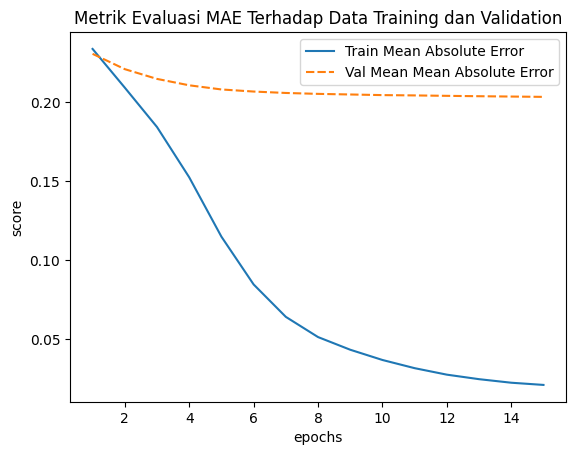

In [49]:
df_result_mae = pd.DataFrame({'Train Mean Absolute Error':history.history['mean_absolute_error'],
                          'Val Mean Mean Absolute Error':history.history['val_mean_absolute_error']}, index=range(1,16))

sns.lineplot(data=df_result_mae)
plt.title('Metrik Evaluasi MAE Terhadap Data Training dan Validation')
plt.xlabel('epochs')
plt.ylabel('score')
plt.show()

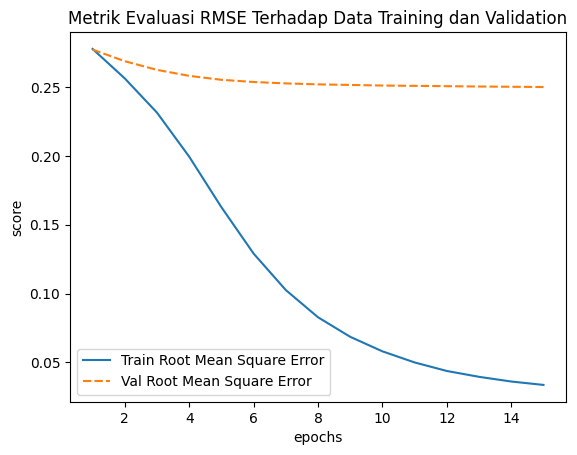

In [50]:
df_result_rmse = pd.DataFrame({'Train Root Mean Square Error':history.history['root_mean_squared_error'],
                          'Val Root Mean Square Error':history.history['val_root_mean_squared_error']}, index=range(1,16))

sns.lineplot(data=df_result_rmse)

plt.title('Metrik Evaluasi RMSE Terhadap Data Training dan Validation')
plt.xlabel('epochs')
plt.ylabel('score')
plt.show()

Insight:
1. Mean Absolute Error (MAE)

* Terlihat bahwa nilai **train MAE** menurun konsisten seiring bertambahnya epoch, menunjukkan bahwa model belajar dengan baik terhadap data latih.
* **Validation MAE** juga menurun dengan kecepatan yang lambat tapi stabil, lalu stagnan di sekitar epoch ke-8 hingga ke-15. Ini menandakan model mulai mengalami **diminishing returns**, namun **belum overfitting** secara signifikan.


2. Root Mean Square Error (RMSE)

* **Train RMSE** juga menurun tajam, dan **val RMSE** stabil turun lalu mendatar. Polanya mirip dengan MAE, artinya model cukup stabil dan tidak mengalami overfitting berat.
* RMSE lebih sensitif terhadap **outlier** dibanding MAE, jadi grafik ini membantu mendeteksi lonjakan kesalahan, tapi dalam kasusmu tetap terlihat smooth dan terkendali.